In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from imblearn.over_sampling import SMOTE
EPS = np.finfo(float).eps
import pickle
from pfimp import plot_feature_importance,plot_summary_fimp

In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
n,d = X.shape
num_iterations = 50
mi_features_y = np.zeros(d)
mi_features   = np.zeros((d,d))
smi_features_y = np.zeros(d)
smi_features   = np.zeros((d,d))

In [3]:
with open('ada_fimp.dat','r') as f:
        ada_fimp, ada_sfimp = pickle.load(f)
with open('gbc_fimp.dat','r') as f:
        gbc_fimp, gbc_sfimp = pickle.load(f)
with open('xgb_fimp.dat','r') as f:
        xgb_fimp, xgb_sfimp = pickle.load(f)

ada_ns = np.mean(ada_fimp,0)
ada_s = np.mean(ada_sfimp,0)
ada_ns_std = np.std(ada_fimp,0)
ada_s_std = np.std(ada_sfimp,0)

gbc_ns = np.mean(gbc_fimp,0)
gbc_s = np.mean(gbc_sfimp,0)
gbc_ns_std = np.std(gbc_fimp,0)
gbc_s_std = np.std(gbc_sfimp,0)

xgb_ns = np.mean(xgb_fimp,0)
xgb_s = np.mean(xgb_sfimp,0)
xgb_ns_std = np.std(xgb_fimp,0)
xgb_s_std = np.std(xgb_sfimp,0)

all_trees_ns = np.concatenate((ada_fimp,gbc_fimp,xgb_fimp),0)
all_trees_s = np.concatenate((ada_sfimp,gbc_sfimp,xgb_sfimp),0)
altrees_ns = np.mean(all_trees_ns,0)
altrees_ns_std = np.std(all_trees_ns,0)
altrees_s = np.mean(all_trees_s,0)
altrees_s_std = np.std(all_trees_s,0)

## Mutual Information calculation

In [4]:
for bb in xrange(num_iterations):
    # print "{0} iteration".format(bb)
    mi_features_y += mutual_info_classif(X,y)
mi_features_y /= float(num_iterations)

In [5]:
for bb in xrange(num_iterations):
    ind = np.random.choice(n,size=10000,replace=False)
    # print "{0} iteration".format(bb)
    for i in xrange(d):
        mi_features[i] += mutual_info_regression(X[ind],X[ind,i])
mi_features /= float(num_iterations)      

In [6]:
sme = SMOTE(ratio=1.0)
sX, sy = sme.fit_sample(X,y)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
for bb in xrange(num_iterations):
    #print "{0} iteration".format(bb)
    smi_features_y += mutual_info_classif(sX,sy)
smi_features_y /= float(num_iterations)

In [8]:
for bb in xrange(num_iterations):
    ind = np.random.choice(n,size=10000,replace=False)
    #print "{0} iteration".format(bb)
    for i in xrange(d):
        smi_features[i] += mutual_info_regression(sX[ind],sX[ind,i])
smi_features /= float(num_iterations)      

# mRMR

mRMR stands for **minimum redunduncy maximum relevance**. Please check out the paper to understand this approach.

#### Non-SMOTE

In [9]:
for i in xrange(d):
    mi_features[i,i] = 0.0
milist = mi_features_y - np.sum(mi_features,axis=1)/(d-1)
ranklist = np.argsort(milist)[::-1] # arg-sort is ascending order. 

In [10]:
ranklist

array([0, 4, 2, 3, 1, 5])

#### SMOTE

In [11]:
for i in xrange(d):
    smi_features[i,i] = 0.0
smilist = smi_features_y - np.sum(smi_features,axis=1)/(d-1)
sranklist = np.argsort(smilist)[::-1] # arg-sort is ascending order.

In [12]:
sranklist

array([0, 2, 3, 4, 1, 5])

In [13]:
with open('mrmr_mi.dat','wb') as f:
    pickle.dump([mi_features_y, mi_features],f)

## Adaboost

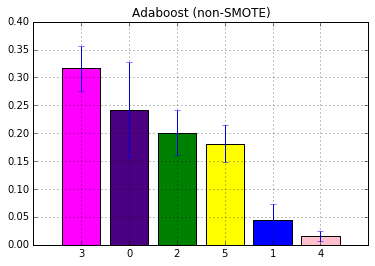

In [14]:
plot_feature_importance(ada_ns,ada_ns_std,'Adaboost (non-SMOTE)')
plt.show()

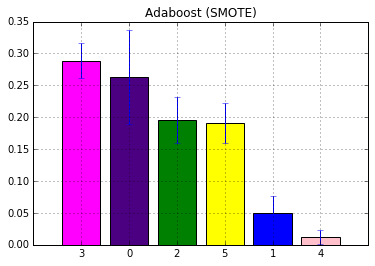

In [15]:
plot_feature_importance(ada_s,ada_s_std,'Adaboost (SMOTE)')
plt.show()

## GBC


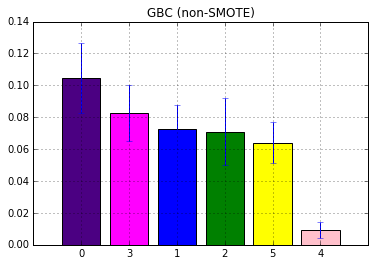

In [16]:
plot_feature_importance(gbc_ns,gbc_ns_std,'GBC (non-SMOTE)')
plt.show()

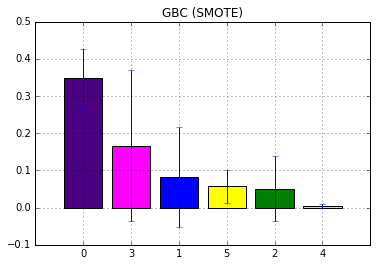

In [17]:
plot_feature_importance(gbc_s,gbc_s_std,'GBC (SMOTE)')
plt.show()

## XGBoost

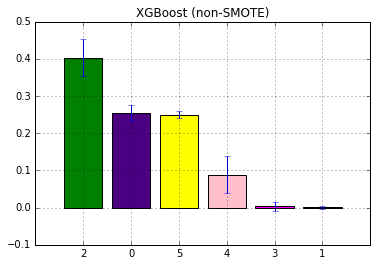

In [18]:
plot_feature_importance(xgb_ns,xgb_ns_std,'XGBoost (non-SMOTE)')
plt.show()

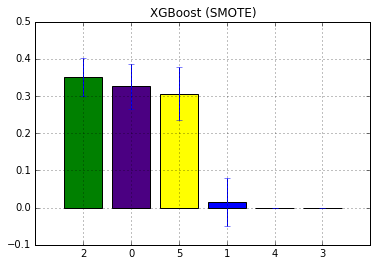

In [19]:
plot_feature_importance(xgb_s,xgb_s_std,'XGBoost (SMOTE)')
plt.show()

## Adaboost + GBC + XGBoost

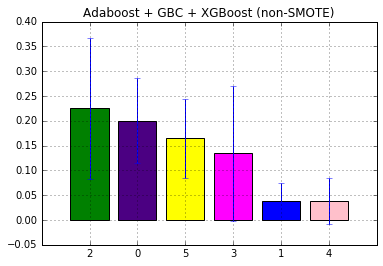

In [20]:
plot_feature_importance(altrees_ns,altrees_ns_std,'Adaboost + GBC + XGBoost (non-SMOTE)')
plt.show()

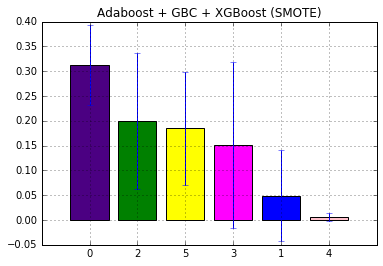

In [21]:
plot_feature_importance(altrees_s,altrees_s_std,'Adaboost + GBC + XGBoost (SMOTE)')
plt.show()

## Plot

In [22]:
ada_p_ns = np.argsort(ada_ns)[::-1]
ada_p_s = np.argsort(ada_s)[::-1]
#
gbc_p_ns = np.argsort(gbc_ns)[::-1]
gbc_p_s = np.argsort(gbc_s)[::-1]
#
xgb_p_ns = np.argsort(xgb_ns)[::-1]
xgb_p_s = np.argsort(xgb_s)[::-1]
#
alt_p_ns = np.argsort(altrees_ns)[::-1]
alt_p_s = np.argsort(altrees_s)[::-1]
#
p_ns = np.vstack((ada_p_ns,gbc_p_ns,xgb_p_ns,ranklist))
p_s = np.vstack((ada_p_s,gbc_p_s,xgb_p_s,sranklist))

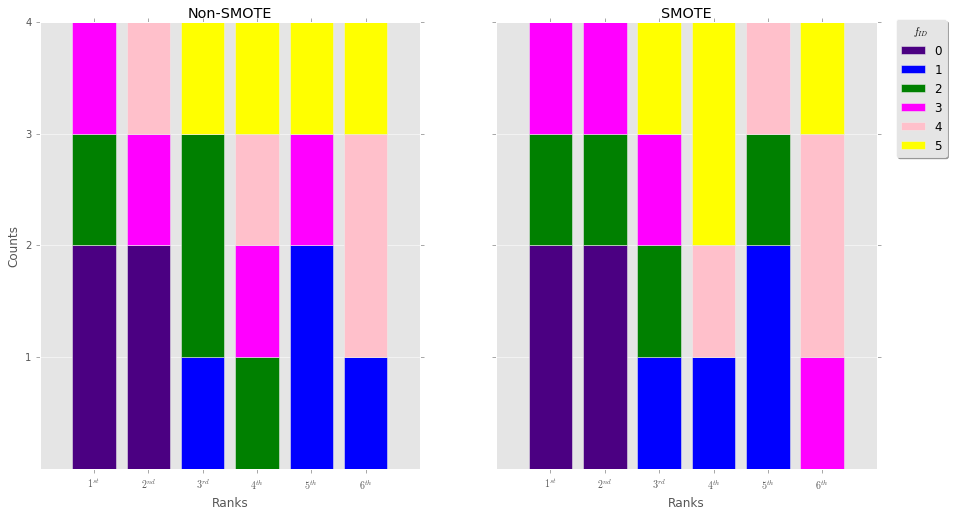

In [61]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(15,8))
xt = ['$1^{st}$','$2^{nd}$','$3^{rd}$','$4^{th}$','$5^{th}$','$6^{th}$']
plt.style.use('ggplot')
#
plt.sca(ax[0])
plot_summary_fimp(p_ns)
plt.xlabel(r'Ranks')
plt.title('Non-SMOTE')
plt.yticks(np.arange(4)+1)
plt.ylabel('Counts')
plt.xticks(np.arange(6), xt)
#
plt.sca(ax[1])
plot_summary_fimp(p_s)
plt.xlabel(r'Ranks')
plt.title('SMOTE')
plt.xticks(np.arange(6), xt)
plt.legend(loc='upper right',bbox_to_anchor=(1.2,1.02),fancybox=True,shadow=True,title='$f_{ID}$')
#
plt.savefig('Summary_FIMP.png')
plt.show()
